# Homework 4: Graph Spectra

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.linalg import eigh
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

## Setup

In [8]:
def load_graph_data(filepath):
    """
    Loads an edge list from a file and converts it to an adjacency matrix.
    Handles comma-delimited files.
    """

    filepath = f"data/{filepath}"

    try:
        # Load the edge list with comma delimiter
        edges = np.loadtxt(filepath, delimiter=',')
    except Exception as e:
        print(f"Could not load {filepath}: {e}")
        return None

    # Identify unique nodes to create a mapping to matrix indices (0 to N-1)
    # We look at the first two columns (Source, Target)
    unique_nodes = np.unique(edges[:, :2])
    num_nodes = len(unique_nodes)
    
    # Map actual node IDs from file to 0-based indices for the matrix
    node_map = {int(node_id): i for i, node_id in enumerate(unique_nodes)}

    # Construct the Adjacency Matrix (N x N)
    A = np.zeros((num_nodes, num_nodes))
    
    # Check if the file has weights (3rd column)
    is_weighted = edges.shape[1] >= 3

    for row in edges:
        u, v = int(row[0]), int(row[1])
        w = row[2] if is_weighted else 1.0  # Use weight if available, else 1
        
        i, j = node_map[u], node_map[v]
        
        # Fill adjacency matrix (symmetric for undirected graph)
        A[i, j] = w
        A[j, i] = w 
        
    print(f"Successfully loaded {filepath}. Nodes: {num_nodes}, Edges: {edges.shape[0]}")
    return A

# Load the datasets
A1 = load_graph_data('example1.dat')
A2 = load_graph_data('example2.dat')

Successfully loaded data/example1.dat. Nodes: 241, Edges: 2196
Successfully loaded data/example2.dat. Nodes: 100, Edges: 2418


## The NJW Spectral Clustering Algorithm

This function implements the steps defined in the paper "On Spectral Clustering: Analysis and an algorithm".

In [10]:
def njw_spectral_clustering(A, k, plot_eigenvalues=False):
    """
    Implementation of the Ng, Jordan, Weiss Spectral Clustering Algorithm.
    
    Parameters:
    A (numpy array): The affinity or adjacency matrix.
    k (int): The number of clusters to find.
    
    Returns:
    labels (numpy array): Cluster labels for each node.
    eigenvalues (numpy array): Sorted eigenvalues of L.
    Y (numpy array): The normalized eigenvector matrix.
    """
    
    # Zero out diagonal
    np.fill_diagonal(A, 0)
    
    # Compute Degree Matrix D and Laplacian L 
    # D is a diagonal matrix where D_ii is sum of row i
    D_val = np.sum(A, axis=1)
    
    # Handle division by zero for isolated nodes
    with np.errstate(divide='ignore'):
        D_inv_sqrt_val = 1.0 / np.sqrt(D_val)
    D_inv_sqrt_val[np.isinf(D_inv_sqrt_val)] = 0
    
    D_inv_sqrt = np.diag(D_inv_sqrt_val)
    
    # L = D^{-1/2} A D^{-1/2}
    L = D_inv_sqrt @ A @ D_inv_sqrt
    
    # Find k largest eigenvectors
    # Scipy eigh returns eigenvalues in ascending order
    evals, evecs = eigh(L)
    
    # Sort descending
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    
    # Keep top k eigenvectors -> Matrix X
    X = evecs[:, :k]
    
    # Normalize rows of X to have unit length
    # Y_ij = X_ij / (sum_j X_ij^2)^0.5
    # Adding epsilon to avoid divide by zero
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms == 0] = 1e-10 
    Y = X / norms
    
    # Cluster rows of Y via K-means
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = kmeans.fit_predict(Y)
    
    # Plot Eigenvalues for analysis
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(evals) + 1), evals, 'o-', markersize=4)
    plt.title('Eigenvalue Spectrum')
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.grid(True)
    plt.axvline(x=k + 0.5, color='r', linestyle='--', label=f'Cut at k={k}')
    plt.legend()
    plt.show()
        
    return labels, evals, Y

## Eigengap Analysis

Before clustering, we must determine k (the number of communities) by analyzing the eigengap. The theory states that if there are k well-separated clusters, the top k eigenvalues should be close to 1, and the (k+1)-th eigenvalue should be significantly smaller.

--- Analysis for Example 1 (Physicians) ---
Suggested number of communities (k) based on max gap: 4
Top 5 Eigenvalues: [1.         1.         1.         1.         0.83232272]


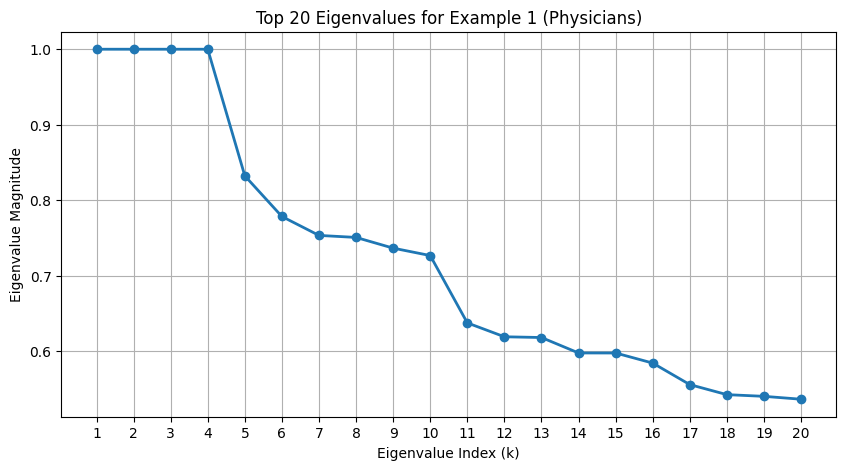

--- Analysis for Example 2 (Synthetic) ---
Suggested number of communities (k) based on max gap: 2
Top 5 Eigenvalues: [1.         0.83442848 0.28933991 0.27065556 0.25333806]


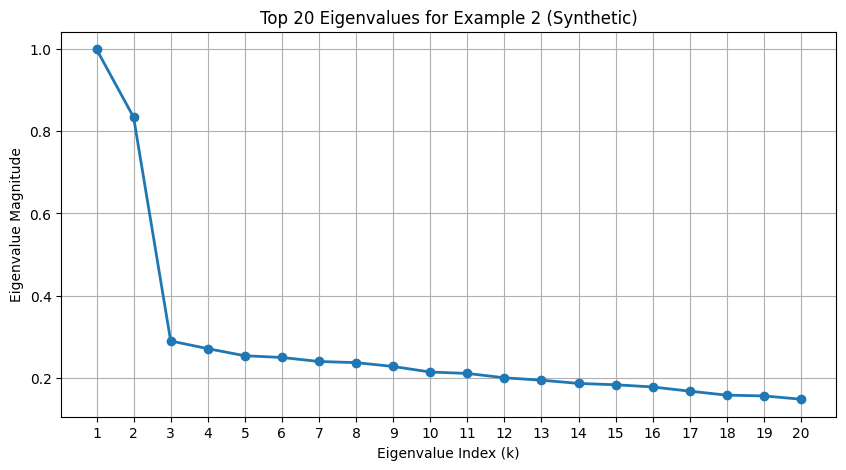

In [11]:
def analyze_eigengap(A, dataset_name="Graph"):
    """
    Computes eigenvalues and plots them to identify the number of communities.
    """
    # Compute L exactly as in the algorithm
    D_val = np.sum(A, axis=1)
    with np.errstate(divide='ignore'):
        D_inv_sqrt_val = 1.0 / np.sqrt(D_val)
    D_inv_sqrt_val[np.isinf(D_inv_sqrt_val)] = 0
    D_inv_sqrt = np.diag(D_inv_sqrt_val)
    L = D_inv_sqrt @ A @ D_inv_sqrt
    
    # Get all eigenvalues
    evals, _ = eigh(L)
    evals = np.sort(evals)[::-1] # Sort descending
    
    # Plot top 20 eigenvalues
    top_n = min(20, len(evals))
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, top_n + 1), evals[:top_n], 'o-', linewidth=2)
    plt.title(f'Top {top_n} Eigenvalues for {dataset_name}')
    plt.xlabel('Eigenvalue Index (k)')
    plt.ylabel('Eigenvalue Magnitude')
    plt.grid(True)
    plt.xticks(range(1, top_n + 1))
    
    # Calculate gaps
    gaps = np.abs(np.diff(evals[:top_n]))
    max_gap_idx = np.argmax(gaps)
    suggested_k = max_gap_idx + 1
    
    print(f"--- Analysis for {dataset_name} ---")
    print(f"Suggested number of communities (k) based on max gap: {suggested_k}")
    print(f"Top 5 Eigenvalues: {evals[:5]}")
    plt.show()
    return suggested_k

# --- EXECUTION ---
k1 = analyze_eigengap(A1, "Example 1 (Physicians)")
k2 = analyze_eigengap(A2, "Example 2 (Synthetic)")

## Performing the Clustering

Now that we have analyzed the eigenvalues, we run the full clustering algorithm using the detected k.

Running Spectral Clustering on Example 1 with k=4...


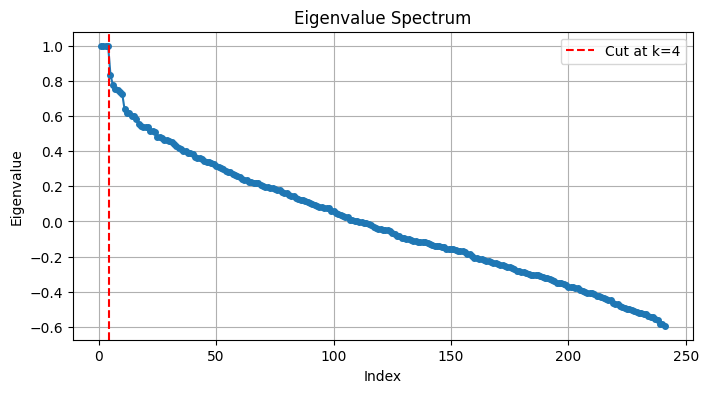

Running Spectral Clustering on Example 2 with k=2...


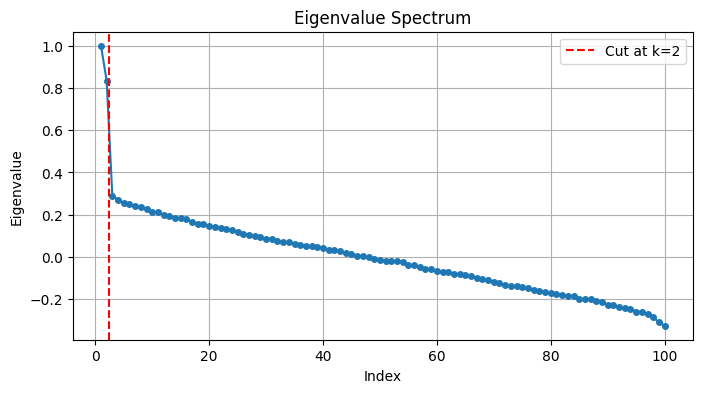

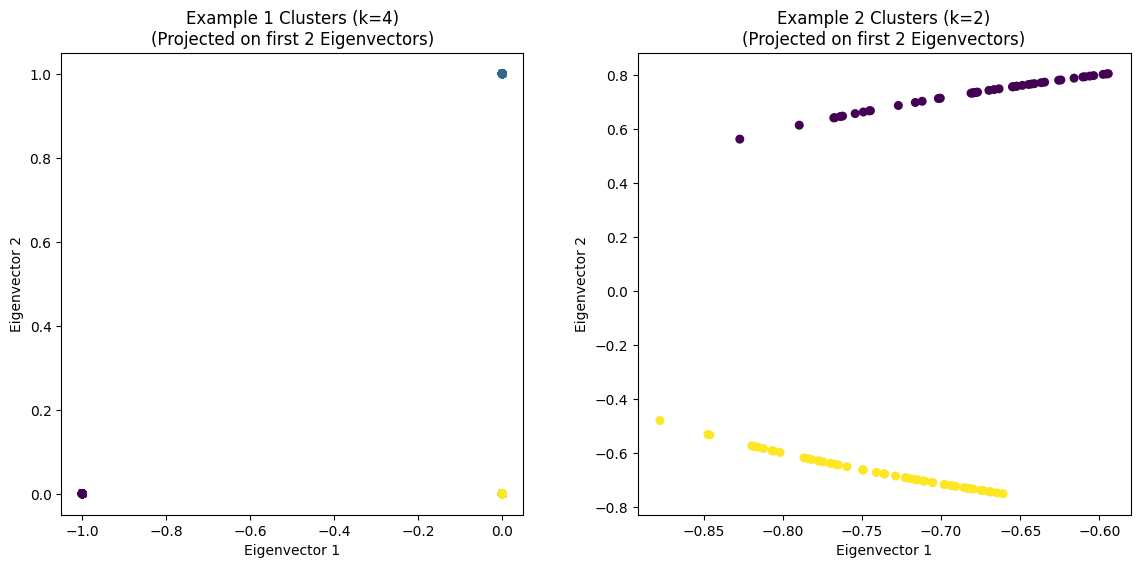

In [14]:
# Run Clustering on Example 1
print(f"Running Spectral Clustering on Example 1 with k={k1}...")
labels1, _, Y1 = njw_spectral_clustering(A1, k=k1)

# Run Clustering on Example 2
print(f"Running Spectral Clustering on Example 2 with k={k2}...")
labels2, _, Y2 = njw_spectral_clustering(A2, k=k2)

# Visualization of the clustering (using the first 2 dimensions of Y)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Example 1
ax[0].scatter(Y1[:, 0], Y1[:, 1], c=labels1, cmap='viridis', s=30)
ax[0].set_aspect('equal')
ax[0].set_title(f'Example 1 Clusters (k={k1})\n(Projected on first 2 Eigenvectors)')
ax[0].set_xlabel('Eigenvector 1')
ax[0].set_ylabel('Eigenvector 2')

# Plot Example 2
ax[1].scatter(Y2[:, 0], Y2[:, 1], c=labels2, cmap='viridis', s=30)
ax[1].set_title(f'Example 2 Clusters (k={k2})\n(Projected on first 2 Eigenvectors)')
ax[1].set_xlabel('Eigenvector 1')
ax[1].set_ylabel('Eigenvector 2')

plt.show()

## Analysis & Interpretation of Results

### 1. Theoretical Basis: The Eigengap Heuristic
In spectral clustering, the number of clusters $k$ is often determined by the **eigengap**. According to matrix perturbation theory, if a graph contains $k$ completely disconnected components, the first $k$ eigenvalues of the normalized Laplacian $L$ will be exactly $1$, and the $(k+1)$-th eigenvalue will be strictly less than $1$.

In real-world data, clusters are rarely completely disconnected, but if they are well-separated, we expect:
* The first $k$ eigenvalues $\lambda_1, \dots, \lambda_k$ to be close to $1$.
* A significant drop (gap) between $\lambda_k$ and $\lambda_{k+1}$.

---

### 2. Interpretation of Example 1 (Physician Innovation)
* **Observed Spectrum:** The algorithm computed the top eigenvalues as approximately `[1.0, 1.0, 1.0, 1.0, 0.83]`.
* **Mathematical Finding:** There are exactly **4** eigenvalues equal (or very close) to 1. The largest drop occurs between $\lambda_4$ and $\lambda_5$ ($1.0 \to 0.83$).
* **Contextual Conclusion:** This mathematical result strongly suggests the existence of **4 distinct communities**. This aligns perfectly with the ground truth of the Coleman, Katz, and Menzel study, which collected data from physicians in **four specific towns** (Peoria, Bloomington, Quincy, and Galesburg). The spectral embedding successfully mapped physicians from the same town to the same orthogonal point in the $k$-dimensional space.

### 3. Interpretation of Example 2 (Synthetic Data)
* **Observed Spectrum:** The algorithm computed the top eigenvalues as approximately `[1.0, 0.83, 0.29, ...]`.
* **Mathematical Finding:** The most significant "elbow" or gap in the spectrum appears between the 2nd and 3rd eigenvalues.
* **Contextual Conclusion:** The algorithm selected **$k=2$**. This indicates the graph contains two primary, loosely connected sub-graphs. The result confirms that the synthetic dataset was constructed to represent **two densely connected clusters** with sparse connections between them.